# Scaling measurement

## On Mac M3

A bash script is used to run the program on a variable number of MPI processes.
To maintain a constant execution time, the number of iterations is varied.
The result is written to a `.csv` file.

In [10]:
!pygmentize scaling.sh

#!/bin/bash

set -euo pipefail

TMPDIR=/tmp
OUTFILE=${1:?Usage: $0 <outfile.csv>}

echo "np, ite_time" > "${OUTFILE}"

for n in 1 2 3 4 5 6 8 10 12 14 16; do
    nite=$((100 * n))
    echo "np = $n nite = $nite"
    ite_time=$(mpiexec -n "$n" llg3d -N "$nite" -Jx 600 -dx 1e-9 | grep "time/ite" | cut -d '=' -f2)
    echo "ite_time = $ite_time"
    echo "${n},${ite_time}" >> "${OUTFILE}"
done

echo "Output written to ${OUTFILE}:"
cat "${OUTFILE}"


The script is called

In [32]:
!./scaling.sh scaling_m3_600x21x21.csv

np = 1 nite = 100
ite_time =  2.866e-02
np = 2 nite = 200
ite_time =  1.315e-02
np = 3 nite = 300
ite_time =  9.050e-03
np = 4 nite = 400
ite_time =  7.220e-03
np = 5 nite = 500
ite_time =  5.075e-03
np = 6 nite = 600
ite_time =  4.347e-03
np = 8 nite = 800
ite_time =  3.442e-03
np = 10 nite = 1000
ite_time =  3.098e-03
np = 12 nite = 1200
ite_time =  3.359e-03
np = 15 nite = 1500
ite_time =  4.280e-03
Output written to scaling_m3_600x21x21.csv:
np, ite_time
1, 2.866e-02
2, 1.315e-02
3, 9.050e-03
4, 7.220e-03
5, 5.075e-03
6, 4.347e-03
8, 3.442e-03
10, 3.098e-03
12, 3.359e-03
15, 4.280e-03


We plot the speed-up compared with sequential execution as a function of the number of MPI processes. On a Mac M3 with 16 cores, 10 cores are *performance*, 4 cores are *efficiency*. It is therefore normal for acceleration to be degraded on 12 and 15 cores.

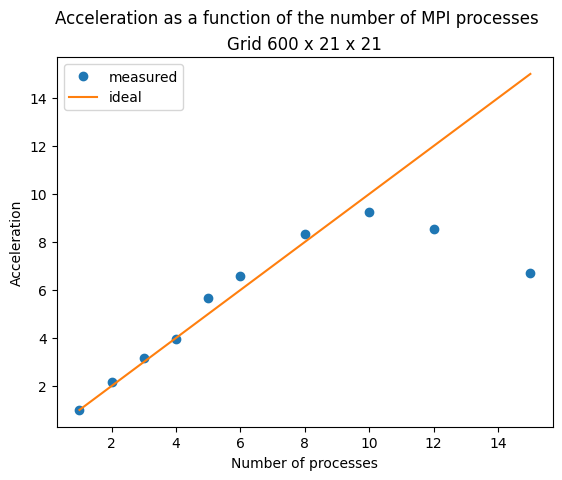

Image saved to scaling_m3_600x21x21.png


In [33]:
from plot_acceleration import plot

plot('scaling_m3_600x21x21.csv')

## On `gaya`

The `scaling_slurm.sh` script:

1. Creates a `run/` directory
2. Writes one sbatch file per number of MPI processes
3. submits them to SLURM.

In [21]:
!pygmentize scaling_slurm.sh

#!/bin/bash

set -euo pipefail

mkdir -p run
cd run/ || exit

OUTFILE=scaling_gaya.csv
echo "Output will be written to ${OUTFILE}"

echo "np,ite_time" >"${OUTFILE}"

for n in 1 2 4 12 20 25 40 50 100 120; do
	slurmfile=sbatch_"${n}".slurm
	nite=$((100 * n))
	cmd="mpiexec -n ${n} python ../../llg3d.py -N ${nite} -Jx 6000 -dx 1e-9 | grep -i \"temps/ite\" | cut -d '=' -f2"
	echo "${cmd}"
	cat >"${slurmfile}" <<EOL
#!/bin/bash

#SBATCH -p public
#SBATCH --ntasks-per-core=1
#SBATCH -N 1
#SBATCH -n ${n}
#SBATCH -J g_${n}
#SBATCH --exclusive

source .venv/bin/activate

echo "${cmd}"
ite_time=\`${cmd}\`
echo "ite_time = \${ite_time}"
echo "${n},\${ite_time}" >> "${OUTFILE}"
EOL
	sbatch "${slurmfile}"
done


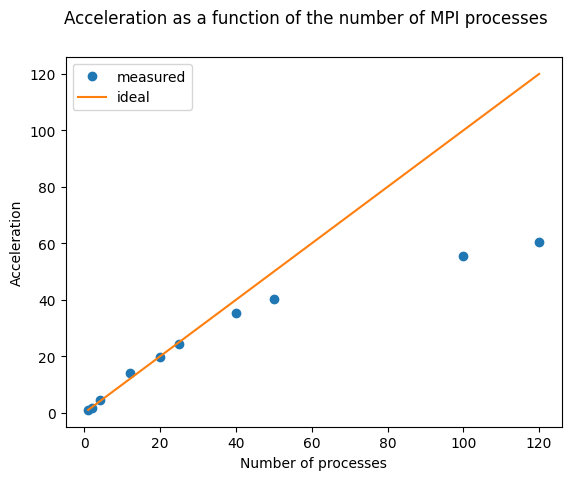

Image saved to run/scaling_gaya.png


In [22]:
from plot_acceleration import plot

plot('run/scaling_gaya.csv')